In [67]:
#https://stackoverflow.com/questions/73071058/fit-data-with-a-lognormal-function-via-maximum-likelihood-estimators/73112103#73112103
#https://towardsdatascience.com/log-normal-distribution-a-simple-explanation-7605864fb67c

In [68]:
from functools import partial
import numpy as np
from scipy import optimize, stats
import matplotlib.pyplot as plt

In [69]:
# %store

In [70]:
%store -r pier_local_scour_depth
%store -r arch_compressive_failure_points_number
%store -r convergence_simulation_number

In [71]:
#Failure probability data from Baker (2015), https://doi.org/10.1193/021113EQS025M
# im = np.array([0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1])
# number_of_analyses = np.array([40, 40, 40, 40, 40, 40, 40, 40])
# number_of_collapses = np.array([0, 0, 0, 4, 6, 13, 12, 16])

In [72]:
#Failure probability data from Qeshta et al., 2021, https://doi.org/10.1080/15732479.2021.1892774
# im = np.array([4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.46])
# number_of_analyses = np.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]) 
# number_of_collapses = np.array([0, 0, 0, 0, 0, 0, 1, 3, 7, 9, 10])

In [89]:
im = []

#if im has an initial value of 0, this leads to -infinite when log is calculated with the lognormal pdf. Therefore, 0 is approximated with 10^-6 for which the code still works.

def replace_zero_im(intensity_measure_vector):
    
    global im #https://scipy-lectures.org/intro/language/functions.html

    for i in range(len(intensity_measure_vector)):
        if intensity_measure_vector[i]==0:
            intensity_measure_vector[i]=10**-6
    
    im = intensity_measure_vector
    return im

In [94]:
#Failure probability data from "twelve_arch_compressive_limit_state_equation.ipynb"
im_input = np.array([0, 0.289, 0.578, 0.867, 1.156, 1.444, 1.733, 2.022, 2.311, 2.6])

In [95]:
replace_zero_im(im_input)

print('im = ', im) #https://stackoverflow.com/questions/21610198/runtimewarning-divide-by-zero-encountered-in-log
number_of_analyses = np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000])
number_of_collapses = np.array([69, 69, 69, 69, 259, 1880, 15286, 74760, 99995, 100000])

im =  [1.000e-06 2.890e-01 5.780e-01 8.670e-01 1.156e+00 1.444e+00 1.733e+00
 2.022e+00 2.311e+00 2.600e+00]


In [96]:
#Above data without the initial zero im value
# im = np.array([0.289, 0.578, 0.867, 1.156, 1.444, 1.733, 2.022, 2.311, 2.6]) #https://stackoverflow.com/questions/21610198/runtimewarning-divide-by-zero-encountered-in-log
# number_of_analyses = np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000])
# number_of_collapses = np.array([69, 69, 69, 259, 1880, 15286, 74760, 99995, 100000])

In [97]:
#Failure probability data from "twelve_arch_compressive_limit_state_equation.ipynb" and other stored values
# im = np.array(pier_local_scour_depth[0])
# number_of_analyses = np.ones(len(pier_local_scour_depth[0]))*convergence_simulation_number
# number_of_collapses = np.array(arch_compressive_failure_points_number)

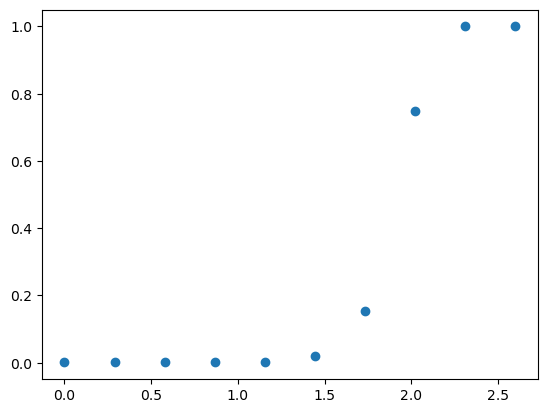

In [98]:
plt.scatter(im, number_of_collapses/number_of_analyses)

In [99]:
#https://stackoverflow.com/questions/21610198/runtimewarning-divide-by-zero-encountered-in-log
np.seterr(divide = 'ignore') #equal to IFERROR function of EXCEL
im_log = np.log(im)

FORMAT_STRING = "{:<20}{:<20}{:<20}"
print(FORMAT_STRING.format("teta", "beta", "log_likelihood_sum"))

teta                beta                log_likelihood_sum  


Implementation to avoid underflow or overflow

In [100]:
def neg_log_likelihood_sum(params, im_l, no_a, no_c):
    
    teta, beta = params

    # log_theoretical_fragility_function = stats.norm.logcdf(im_l, np.log(teta), beta) #fisrt approach
    # theoretical_fragility_function = np.exp(log_theoretical_fragility_function) #first approach
    log_theoretical_fragility_function = stats.lognorm.logcdf(x=im, s=beta, loc=0, scale=teta) #second approach
    theoretical_fragility_function = np.exp(log_theoretical_fragility_function) #second approach

    log_likelihood = stats.binom.logpmf(no_c, no_a, theoretical_fragility_function)
    log_likelihood_sum = np.sum(log_likelihood)

    print(FORMAT_STRING.format(teta, beta, log_likelihood_sum))
    
    return -log_likelihood_sum

In [101]:
guess_values = (1.6, 0.4) #guess_values = (1.6, 0.1) for Baker, = (1.6, 0.4) for my data, while guess_values = (8, 0.1) for Qeshta et al. (2021) data. Be aware to use 'reasonable' guess data.
params_bounds = ((0.01, None), (0.01, None)) #teta and beta must be positive because of the problem physics
desired_tolerance = 10**-3
number_of_iterations = 1000

# https://www.udacity.com/blog/2020/12/how-to-create-partial-functions-in-python.html#:~:text=What%20is%20a%20Partial%20Function,extension%20of%20another%20specified%20function.
neg_log_likelihood_sum_partial = partial(neg_log_likelihood_sum, im_l=im_log, no_a=number_of_analyses, no_c=number_of_collapses)

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
res = optimize.minimize(neg_log_likelihood_sum_partial, x0 = guess_values, 
                method="Nelder-Mead", options={'maxiter':number_of_iterations, 
                'disp':True}, bounds = params_bounds, tol = desired_tolerance)
print(res)

1.6                 0.4                 -185333.4207731888  
1.6800000000000002  0.4                 -173166.32571673577 
1.6                 0.42000000000000004 -186782.70388029766 
1.6800000000000002  0.38                -171610.21971362675 
1.7199999999999998  0.3600000000000001  -inf                
1.7600000000000002  0.38                -164022.55083630758 
1.8400000000000007  0.3699999999999999  -inf                
1.7600000000000002  0.36                -inf                
1.7000000000000002  0.39                -170010.7163315206  
1.7800000000000002  0.39                -163780.74273908712 
1.83                0.395               -162604.58593535333 
1.8900000000000001  0.385               -161644.34413598548 
1.9850000000000003  0.38250000000000006 -165597.8888591954  
1.96                0.4                 -165358.269011201   
1.81                0.385               -162101.84610934078 
1.87                0.375               -inf                
1.84                0.39

Try to including 0

In [82]:
xx=1**-11
beta=0.4
teta=1.5

In [83]:
theoretical_fragility_function = stats.norm(np.log(teta), beta).cdf(np.log(xx))
print(theoretical_fragility_function)

0.15537184730329506


In [84]:
theoretical_fragility_function = stats.norm.logcdf(np.log(xx), np.log(teta), beta)
print(theoretical_fragility_function)
print(np.exp(theoretical_fragility_function))

-1.8619340202450088
0.155371847303295


In [85]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
theoretical_fragility_function = stats.lognorm.cdf(x=xx, s=beta, loc=0, scale=teta)
print(theoretical_fragility_function)

0.155371847303295


In [86]:
theoretical_fragility_function = stats.lognorm.logcdf(x=xx, s=beta, loc=0, scale=teta)
print(theoretical_fragility_function)
print(np.exp(theoretical_fragility_function))

-1.861934020245009
0.15537184730329498


In [87]:
no_c = 69
no_a = 100_000

In [88]:
log_likelihood = stats.binom.logpmf(no_c, no_a, np.exp(theoretical_fragility_function))
print(log_likelihood)
print(np.exp(log_likelihood))

-16434.52479231295
0.0
